<a href="https://colab.research.google.com/github/martianmartina/FaceEditor/blob/master/tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'FaceEditor'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

In [3]:
%cd /content/drive/My\ Drive/$FOLDERNAME

/content/drive/My Drive/FaceEditor


In [4]:
import os, gc, zipfile
import random
import numpy as np, pandas as pd

from tqdm import tqdm
from io import BytesIO
import matplotlib.pyplot as plt

import cv2
from google.colab.patches import cv2_imshow
import tensorflow as tf
import keras
from keras.preprocessing.image import img_to_array

PATH = './photos/'
IMAGES = os.listdir(PATH)
print('There are',len(IMAGES),'images. Here are 5 example filesnames:')
print(IMAGES[:5])

There are 188 images. Here are 5 example filesnames:
['m-039-01.jpg', 'm-027-01.jpg', 'm-078-01.jpg', 'm-072-01.jpg', 'm-018-01.jpg']


In [5]:
# Not used now
def showarray(a, fmt='jpeg'):
    ''' Helper function. Use this to show your filters
    
    Converting to standard image format is a common task that produces garbage
    images when not done correctly. We've provided the correct conversions'''
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [6]:
def brightness(img, low, high):
    value = random.uniform(low, high)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

In [7]:
imgs_array=[]
for i in range(len(IMAGES)):
  image = cv2.imread(PATH + IMAGES[i%len(IMAGES)])
  # as opencv load image in bgr format converting it to rgb
  #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  
  image = cv2.resize(image,( 128, int(image.shape[0]/(image.shape[1]/128)) ))
  # cropping + better to choose convtranspose parameter
  image = image[12:140,:]       # (128,128,3)
  imgs_array.append(img_to_array(image))
  
  # data augmentation: 
  # horizontal flip
  image_1 = cv2.flip(image,1)
  imgs_array.append(img_to_array(image))
  # brightness
  image_2 = brightness(image,0.6,1.3)
  imgs_array.append(img_to_array(image_2))
  # horizontal flip + brightness
  image_3 = brightness(image_1,0.6,1.3)
  imgs_array.append(img_to_array(image_3))

import random
random.shuffle(imgs_array)

In [8]:
imgs_array = np.asarray(imgs_array,dtype=np.float32)
print(imgs_array.shape)

#Spliting the data
imgs_train_y = imgs_array[:700]/255.0
imgs_test = imgs_array[700:]/255.0
imgs_train_x = np.expand_dims(np.arange(imgs_train_y.shape[0]), axis=1)
print(imgs_train_y.shape)
print(imgs_train_x.shape)

(752, 128, 128, 3)
(700, 128, 128, 3)
(700, 1)


In [9]:
tf.config.experimental.list_physical_devices('GPU')

[]

In [10]:
import sys
from dutil import *
import pydot

SHIFT_AMOUNT = 9
BATCH_SIZE = 8
NUM_KERNELS = 20
CONTINUE_TRAIN = False
SIZE = 128 # 128*128 image

NUM_EPOCHS = 2000
PARAM_SIZE = 80
LR = 0.001
NUM_RAND_FACES = BATCH_SIZE
NUM_TEST_FACES = BATCH_SIZE

def plotScores(scores, test_scores, fname, on_top=True):
	plt.clf()
	ax = plt.gca()
	ax.yaxis.tick_right()
	ax.yaxis.set_ticks_position('both')
	ax.yaxis.grid(True)
	plt.plot(scores)
	plt.plot(test_scores)
	plt.xlabel('Epoch')
	plt.ylim([0.0, 0.01])
	loc = ('upper right' if on_top else 'lower right')
	plt.legend(['Train', 'Test'], loc=loc)
	plt.draw()
	plt.savefig(fname)


In [11]:

###################################
#  Create Model
###################################
print ("Loading Keras...")
import os, math
os.environ['THEANORC'] = "./gpu.theanorc"
os.environ['KERAS_BACKEND'] = "theano"
import theano
print( "Theano Version: " + theano.__version__)

from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Flatten, Reshape, SpatialDropout2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import Embedding
from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')

num_samples = imgs_train_y.shape[0]

if CONTINUE_TRAIN:
	print("Loading Model...")
	model = load_model('Encoder.h5')
else:
	print ("Building Model...")
 
	model = Sequential()
	model.add(Input(shape=(1)))
	
	model.add(Embedding(num_samples, PARAM_SIZE, input_length=1))
	model.add(Flatten(name='pre_encoder'))
	print(model.output_shape)            #(None, 80)
	assert(model.output_shape == (None, PARAM_SIZE))
	
	model.add(Reshape((1,1,PARAM_SIZE), name='encoder'))
	print( model.output_shape)
	
	model.add(Conv2DTranspose(128, 2))           
	model.add(Activation("relu"))
	print(model.output_shape)

	model.add(Conv2DTranspose(64, 4, strides=2))    #(6, 6)              
	model.add(Activation("relu"))
	print(model.output_shape)
	
	model.add(Conv2DTranspose(32, 4, strides=2))    #(14, 14)            
	model.add(Activation("relu"))
	print(model.output_shape)
	
	model.add(Conv2DTranspose(16, 4, strides=2))    #(30, 30)  
	model.add(Activation("relu"))
	print(model.output_shape)
	
	model.add(Conv2DTranspose(8, 4, strides=2))    #(62, 62)
	model.add(Activation("relu"))
	print(model.output_shape)
	

	model.add(Conv2DTranspose(3, 6, strides=2))     #(128, 128)
	model.add(Activation("sigmoid",name='output')) 
	print(model.output_shape)
	assert(model.output_shape[1:] == (128,128,3))

	model.compile(optimizer=Adam(learning_rate=LR), loss='mse')
	plot_model(model, to_file='model.png', show_shapes=True)

Loading Keras...


ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.7 or higher required)
NoneType: None


Theano Version: 1.1.2
Building Model...
(None, 80)
(None, 1, 1, 80)
(None, 2, 2, 128)
(None, 6, 6, 64)
(None, 14, 14, 32)
(None, 30, 30, 16)
(None, 62, 62, 8)
(None, 128, 128, 3)


Compiling SubModels...


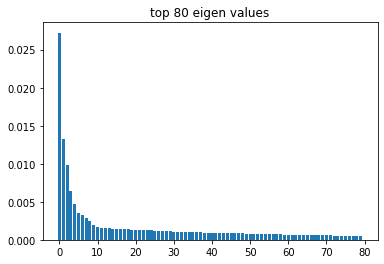

In [16]:
###################################
#  Encoder / Decoder
###################################
print( "Compiling SubModels...")
#print(model.layers[1].output)
#print(model.layers[-1])
func = Model(inputs=model.get_layer('encoder').input,
				  outputs=model.layers[-1].output)
enc_model = Model(inputs=model.input,
                  outputs=model.get_layer('pre_encoder').output)

rand_vecs = np.random.normal(0.0, 1.0, (NUM_RAND_FACES, PARAM_SIZE))

def save_image(x, fname):
    img = x*255
    #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    cv2.imwrite(fname, img)
def make_rand_faces(rand_vecs, iters):
    x_enc = enc_model.predict(imgs_train_x, batch_size=BATCH_SIZE)
	
    x_mean = np.mean(x_enc, axis=0)
    x_stds = np.std(x_enc, axis=0)
    x_cov = np.cov((x_enc - x_mean).T)
    e, v = np.linalg.eig(x_cov)
 
    np.save('means.npy', x_mean)
    np.save('stds.npy', x_stds)
    np.save('evals.npy', e)
    np.save('evecs.npy', v)
 
    e_list = e.tolist()
    e_list.sort(reverse=True)
    plt.clf()
    plt.bar(np.arange(e.shape[0]), e_list, align='center')
    plt.draw()
    plt.title('top 80 eigen values')
    plt.savefig('evals.png')
    x_vecs = x_mean + np.dot(v, (rand_vecs * e).T).T
    y_faces = func.predict(x_vecs)
    for i in range(y_faces.shape[0]):
        #channels_first = np.transpose(y_faces[i],(2,0,1)) # (3, 128, 128)
        save_image(y_faces[i], 'rand' + str(i) + '.png')
        if i < 5 and (iters % 10) == 0:
            if not os.path.exists('morph' + str(i)):
                os.makedirs('morph' + str(i))
            save_image(y_faces[i], 'morph' + str(i) + '/img' + str(iters) + '.png')

make_rand_faces(rand_vecs, 0)
			

In [ ]:
###################################
#  Train
###################################
print( "Training...")
train_loss = []

for iters in range(NUM_EPOCHS):
    history = model.fit(imgs_train_x, imgs_train_y, batch_size=BATCH_SIZE, epochs=1)

    loss = history.history['loss'][-1]
    train_loss.append(loss)
    print("Loss: " + str(loss))
    plotScores(train_loss, [], 'EncoderScores.png', True)
	
    if iters % 20 == 0:
        model.save('Encoder.h5')
        y_faces = model.predict(imgs_train_x[:NUM_TEST_FACES], batch_size=BATCH_SIZE)
        for i in range(y_faces.shape[0]):
            #channels_first = np.transpose(y_faces[i],(2,0,1))
            save_image(y_faces[i], 'gt' + str(i) + '.png')
        make_rand_faces(rand_vecs, iters)
        print("Saved")
print("Done")

Training...
88/88 [==============================] - 6s 67ms/step - loss: 0.0098
Loss: 0.009787318296730518
Saved
88/88 [==============================] - 5s 58ms/step - loss: 0.0095
Loss: 0.00948250200599432
88/88 [==============================] - 5s 59ms/step - loss: 0.0091
Loss: 0.009106850251555443
88/88 [==============================] - 5s 57ms/step - loss: 0.0088
Loss: 0.008817631751298904
88/88 [==============================] - 5s 58ms/step - loss: 0.0086
Loss: 0.008609160780906677
88/88 [==============================] - 5s 57ms/step - loss: 0.0083
Loss: 0.00829312764108181
88/88 [==============================] - 5s 58ms/step - loss: 0.0080
Loss: 0.007967221550643444
88/88 [==============================] - 5s 58ms/step - loss: 0.0077
Loss: 0.007704172283411026
88/88 [==============================] - 5s 58ms/step - loss: 0.0074
Loss: 0.007409438956528902
88/88 [==============================] - 5s 57ms/step - loss: 0.0072
Loss: 0.007174626924097538
88/88 [=================

In [ ]:
print(func)
print(enc_model)